# Freight Pricing API Time Series Example

This Jupyter Notebook displays a use case of how we could use the Freight Pricing API in order to conduct a time series analysis regarding the freight rates.
But first we should make sure that the Signal Ocean SDK is installed and the user's API key is set in `SIGNAL_OCEAN_API_KEY` environment variable.

In [1]:
import pandas as pd
import datetime as dt

We will also use PortAPI in order to choose Load & Discharge ports.

In [2]:
from signal_ocean import PortAPI, PortFilter, Connection

port_api = PortAPI()

load_port = port_api.get_ports(PortFilter(name_like='Gamba'))[0]
discharge_port = port_api.get_ports(PortFilter(name_like='Singapore'))[0]

In [3]:
from signal_ocean.freight_pricing import FreightPricingAPI,VesselType,VesselSubclass
from datetime import date

### Creating Time Series Data 

Time Series data are created by calling the Freight Pricing API iteratively. Τime Window and Frequency are determined by first_day, last_day and weeks_before variables. In this specific example we will get the freight rates for every week for the last 52 weeks. Reference day is the present day of week.

In [4]:
freight_pricing_api = FreightPricingAPI()

last_day = date.today() + pd.DateOffset(days= -1) #- pd.DateOffset(days= (- or +)...) To pick a specific date
weeks_before = 52 # here the number of weeks back can change
first_day = last_day + pd.DateOffset(days= -weeks_before*7)

df_dict = {}

for i in range(1,weeks_before+1):
    next_date = first_day + pd.DateOffset(days=i*7)
    freight_pricing_collection = freight_pricing_api.get_freight_pricing(
        vessel_type=VesselType(id=1, name='Tanker'),
        load_port=load_port, 
        discharge_port=discharge_port,
        date=next_date,
        vessel_subclass=VesselSubclass.DIRTY)
    temp_dict = [o.__dict__ for o in freight_pricing_collection]
    for item in temp_dict:
        item['costs']= item['costs'].__dict__ 
        item['totals']= item['totals'].__dict__ 
    dataf = pd.json_normalize(data=temp_dict)
    fr_series = dataf['costs.freight_rate']
    df_dict[str(next_date)] = fr_series.values.tolist()
    
vessel_classes = dataf.vessel_class.tolist()
df_dict["vessel_class"] = vessel_classes

In [5]:
final_df = pd.DataFrame.from_dict(df_dict)
final_df

,2019-10-29 00:00:00,2019-11-05 00:00:00,2019-11-12 00:00:00,2019-11-19 00:00:00,2019-11-26 00:00:00,2019-12-03 00:00:00,2019-12-10 00:00:00,2019-12-17 00:00:00,2019-12-24 00:00:00,2019-12-31 00:00:00,...,2020-08-25 00:00:00,2020-09-01 00:00:00,2020-09-08 00:00:00,2020-09-15 00:00:00,2020-09-22 00:00:00,2020-09-29 00:00:00,2020-10-06 00:00:00,2020-10-13 00:00:00,2020-10-20 00:00:00,vessel_class
0,23.3759575,22.10928,19.2304675,19.575925,26.8305325,23.6062625,23.49111,24.2971775,27.5214475,27.2911425,...,11.01024,9.63396,8.808192,11.285496,10.597356,10.046844,9.496332,9.083448,9.083448,VLCC
1,36.9639525,26.945685,21.5335175,28.9032775,30.2851075,29.47904,34.08514,34.08514,38.69124,40.99429,...,14.45094,14.175684,11.147868,12.661776,11.69838,11.147868,11.836008,11.285496,11.285496,Suezmax
2,28.55782,25.6790075,25.6790075,44.67917,47.5579825,47.5579825,44.1034075,46.98222,49.28527,50.436795,...,20.6442,19.26792,18.57978,18.57978,18.57978,18.57978,18.57978,18.57978,18.57978,Aframax


Transposed dataframe is helpfull for the visualization of the data

In [6]:
final_df_transposed = final_df.set_index("vessel_class").T.rename_axis('Date')
final_df_transposed.head()

vessel_class,VLCC,Suezmax,Aframax
Date,,,
2019-10-29 00:00:00,23.3759575,36.9639525,28.55782
2019-11-05 00:00:00,22.10928,26.945685,25.6790075
2019-11-12 00:00:00,19.2304675,21.5335175,25.6790075
2019-11-19 00:00:00,19.575925,28.9032775,44.67917
2019-11-26 00:00:00,26.8305325,30.2851075,47.5579825


In [7]:
# extracting the transposed ton an excel file
final_df.to_excel('simpleDemoFreightPricing.xlsx')

## Visualizing the results in a graph

In [8]:
# creating x axis for the graph
variables_dict={}
for vc in  final_df.vessel_class.tolist():
    variables_dict["var%s" %vc] = final_df.loc[final_df.vessel_class==vc,str(first_day):str(last_day)].values.tolist()[0]

x_axis = final_df.loc[1:-1,str(first_day):str(last_day)].columns.tolist()
x_axis = [dt.datetime.strptime(x[0:10], '%Y-%m-%d') for x in x_axis]


In [9]:
#restrain the y axis
import numpy as np

minim = np.amin(final_df.loc[:,str(first_day):str(last_day)].values)
maxim = np.amax(final_df.loc[:,str(first_day):str(last_day)].values)

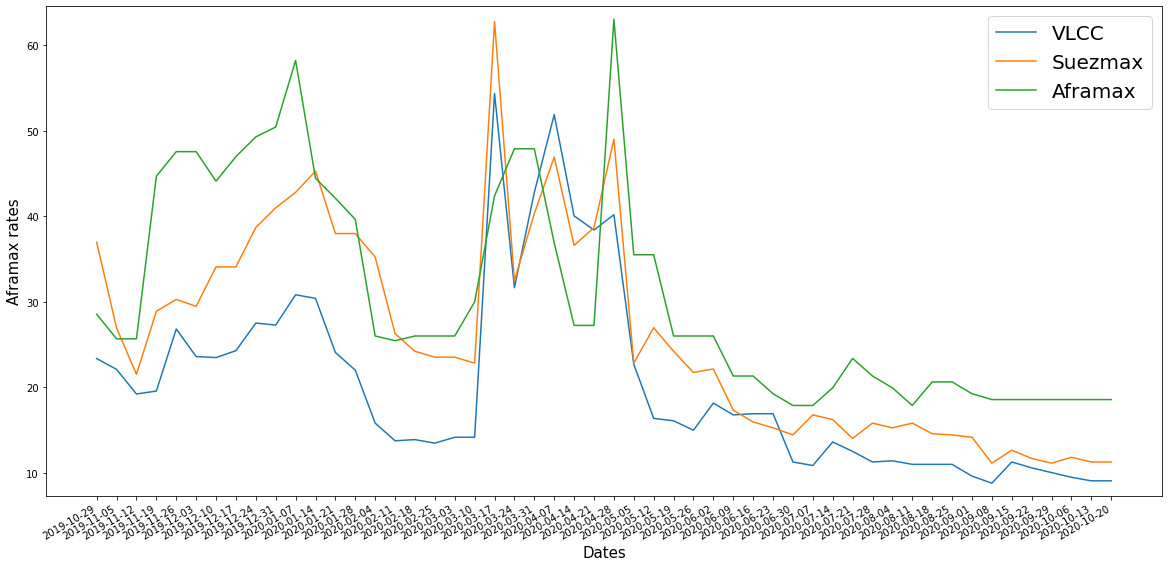

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import decimal

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.axes.set_ylim([minim - decimal.Decimal(1.5) ,maxim + decimal.Decimal(1.5)])
ax.axes.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

for key,val in variables_dict.items():
    ax.plot(x_axis,val,label=key[3:])

plt.xticks(x_axis)

plt.xlabel("Dates", fontsize=15)
plt.ylabel("Aframax rates", fontsize=15)

plt.legend(fontsize=20)

# format your data to desired format. Here I chose YYYY-MM-DD but you can set it to whatever you want.
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# rotate and align the tick labels so they look better
fig.autofmt_xdate()